In [6]:
import pandas as pd 
from sklearn.model_selection import train_test_split

df = pd.read_excel('./AmazonSaleReport.xlsx', parse_dates=['Date'], index_col='Date')
df = df.sort_index()

# A little bit of data cleaning
df.drop(['Order ID', 'Status', 'Unnamed: 22', 'SKU', 'ASIN', 'Courier Status', 'ship-city', 'ship-state', 'ship-postal-code', 'ship-country', 'Style'], axis=1, inplace=True)

# Getting dummies and changing column names
# Fullfillment
df['fulfilled-by'] = df['fulfilled-by'].apply(lambda x: True if x == 'Easy Ship' else False)
df.rename(columns={'fulfilled-by': 'fulfilledEasyShip'}, inplace=True)

# Fullfillment again?
df['Fulfilment'] = df['Fulfilment'].apply(lambda x: True if x == 'Amazon' else False)
df.rename(columns={'Fulfilment': 'FBA'}, inplace=True)

# Sales channel
df['Sales Channel '] = df['Sales Channel '].apply(lambda x: True if x == 'Amazon.in' else False)
df.rename(columns={'Sales Channel ': 'soldAmazonIn'}, inplace=True)

# Currency
df['currency'] = df['currency'].apply(lambda x: True if x == 'INR' else False)
df.rename(columns={'currency': 'paidINR'}, inplace=True)

# Ship-Service-Level
df['ship-service-level'] = df['ship-service-level'].apply(lambda x: True if x == 'Standard' else False)
df.rename(columns={'ship-service-level': 'standardShipping'}, inplace=True)

# Check if it has promotions, convert to boolean
df['promotion-ids'] = df['promotion-ids'].apply(lambda x: False if pd.isna(x) else True)

# Size
df_dummies = pd.get_dummies(df, columns=['Size'])

# Categories
categories_to_delete = ['Ethnic Dress', 'Blouse', 'Bottom', 'Saree', 'Dupatta']
df_dummies = df_dummies[~df_dummies['Category'].isin(categories_to_delete)]
df_dummies = pd.get_dummies(df_dummies, columns=['Category'])

# Drop NaNs
df_dummies.dropna(inplace=True)
df_dummies.head()

X = df_dummies.drop(columns='Amount')
Y = df_dummies['Amount']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [20]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X = X_train, Y = Y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
model = grid_search.best_estimator_

print(f'Best parameters: {best_params}')

AttributeError: 'super' object has no attribute '__sklearn_tags__'

Mean Squared Error: 47011.58526352233


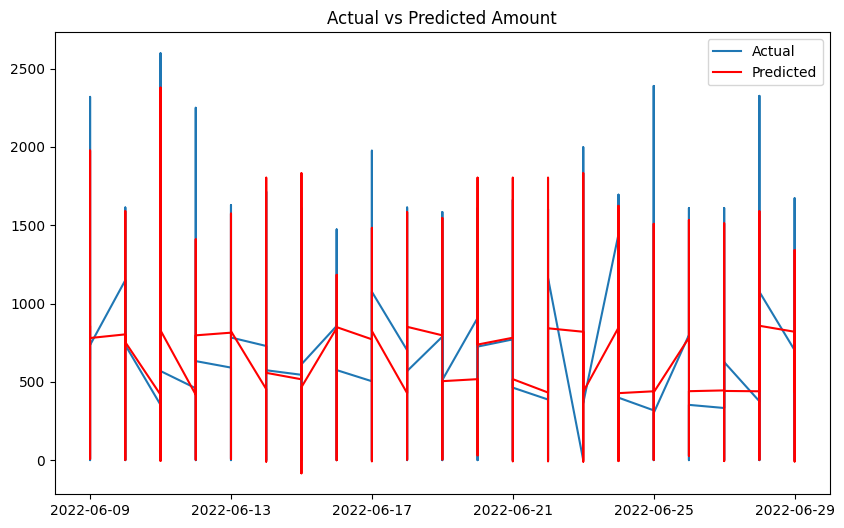

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(Y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(Y_test.index, Y_test, label='Actual')
plt.plot(Y_test.index, y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Amount')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_absolute_error, r2_score

# Mean absolute error
mae = mean_absolute_error(Y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# R-squared value
r2 = r2_score(Y_test, y_pred)
print(f'R-squared: {r2}')

Mean Absolute Error: 156.04468535192467
R-squared: 0.43946291531956716
